In [1]:
import json
import pathlib
from functools import reduce

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.transforms as transforms
from matplotlib.ticker import FormatStrFormatter
from fastdtw import fastdtw
import statsmodels
import statsmodels.stats.multitest
from scipy.stats import mannwhitneyu

import cliffdelta

%matplotlib inline

In [2]:
FRAMEWORKS = [
    "pytorch",
    "tensorflow",
]

MODELS = [
    "lenet1",
    "lenet5",
    "vgg16",
    "lstm",
    "gru",
    "grurb",
]

LANGUAGES = [
    "py",
    "dotnet",
    "rs",
    "ts",
]

LANG_SHOW_MAP = {
    "py": "Python",
    "dotnet": "C#",
    "rs": "Rust",
    "ts": "JS",
}

MODELS_SHOW_MAP = {
    "lenet1": "LeNet-1",
    "lenet5": "LeNet-5",
    "vgg16": "VGG-16",
    "lstm": "LSTM",
    "gru": "GRU",
}

MODE_SHOW_MAP = {
    "states": "states",
    "serialization": "serialization",
}

DATA_PATH = pathlib.Path("./data")
def getPath(framework, model, language):
    dir_path = DATA_PATH / framework / model / language
    return dir_path if dir_path.exists() else None

def loadJson(path):
    with open(path, 'r') as f:
        return json.load(f)

OUT_PATH = pathlib.Path("./out")
OUT_PATH.mkdir(exist_ok=True)
OUT_FIGS_PATH = OUT_PATH / "figs"
OUT_FIGS_PATH.mkdir(exist_ok=True)

## RQ1. How do the studied bindings impact the training accuracy and test accuracy of the studied DL models?

### Collecting information

In [3]:
info_files = {
    "training_errors": ["training_errors_", "txt"],
    "testing_errors": ["testing_errors_", "txt"],
}
infos = {}

for info_name, file_fmt in info_files.items():
    infos.setdefault(info_name, {})
    for fw in FRAMEWORKS:
        infos[info_name].setdefault(fw, {})
        for m in MODELS:
            infos[info_name][fw].setdefault(m, {})
            for l in LANGUAGES:
                dir_p = getPath(fw, m, l)
                if dir_p is None:
                    continue
                for i in range(5):
                    file_p = dir_p / f"{file_fmt[0]}{i}.{file_fmt[1]}"
                    if not file_p.exists():
                        continue
                    infos[info_name][fw][m].setdefault(l, [])
                    data = np.loadtxt(file_p)
                    infos[info_name][fw][m][l].append(data)

### Training accuracies in each binding

In [4]:
idxes = {}
for fw, fw_info in infos["testing_errors"].items():
    idxes.setdefault(fw, {})
    for m, m_info in fw_info.items():
        idxes[fw].setdefault(m, {})
        for l, l_info in m_info.items():
            idxes[fw][m].setdefault(l, {})
            # figure, (ax1, ax2) = plt.subplots(1, 2)
            # figure.set_size_inches((12, 4))
            # for idx in range(5):
            #     ax1.plot(infos["training_errors"][fw][m][l][idx], label=f"{fw}_{m}_{l}_{idx}")
            #     ax2.plot(l_info[idx], label=f"{fw}_{m}_{l}_{idx}")
            # ax1.set_title("Training accuracy")
            # ax2.set_title("Testing accuracy")
            # ax1.legend()
            # ax2.legend()
            # figure.savefig(OUT_FIGS_PATH / f"{fw}_{m}_{l}.eps", bbox_inches='tight')
            idxes[fw][m][l]["max"] = max(range(len(l_info)), key=lambda i: l_info[i][-1])
            idxes[fw][m][l]["mid"] = sorted(range(len(l_info)), key=lambda i: l_info[i][-1])[len(l_info) // 2]

### Training accuracies group by library x model

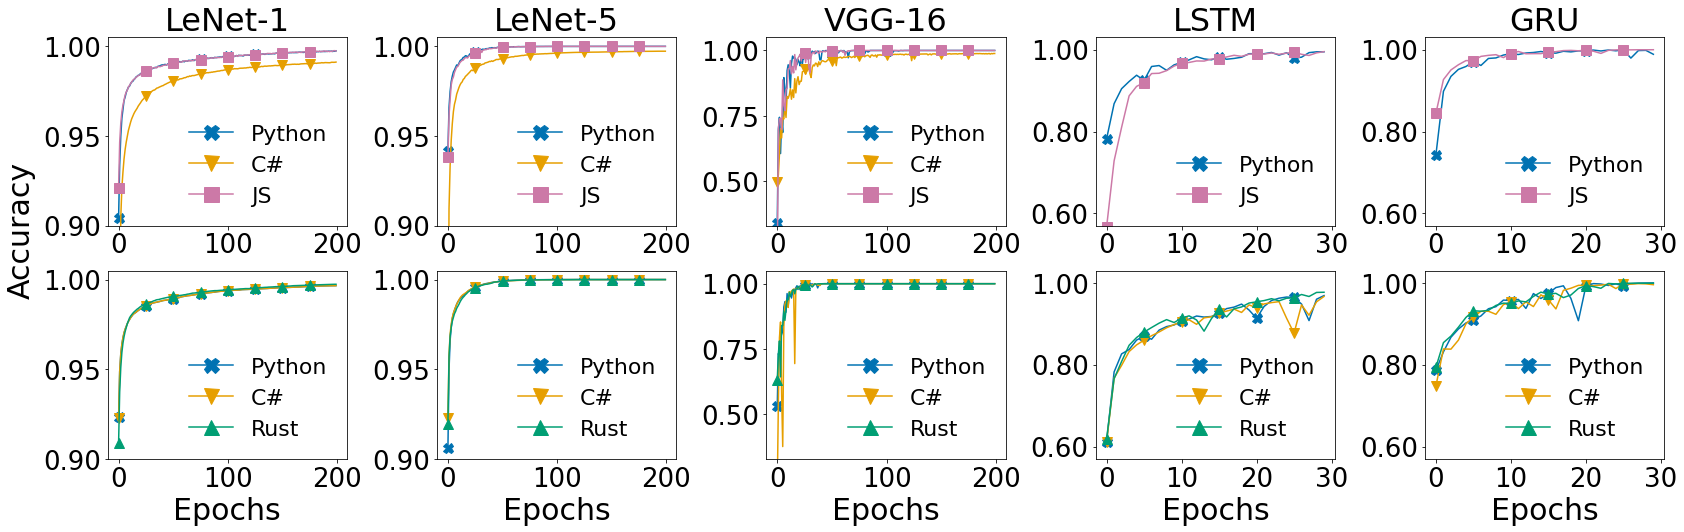

In [5]:
COLOR_MAP = {
    "py": "#0072B2",
    "dotnet": "#E69F00",
    "ts": "#CC79A7",
    "rs": "#009E73",
}

MARKER_MAP = {
    "py": "X",
    "dotnet": "v",
    "ts": "s",
    "rs": "^",
}

MARKEVERY_MAP = {
    "grurb": 5,
    "gru": 5,
    "lstm": 5,
    "lenet1": 25,
    "lenet5": 25,
    "vgg16": 25,
}

LEGEND_SIZE = 22
TICK_SIZE = 26
LABEL_SIZE = 30
TITLE_SIZE = 32

def drawErrors(ax, errorName: str, draw_idx: str, draw_fws, draw_ms, draw_ls):
    for fw in draw_fws:
        for m in draw_ms:
            if fw == "tensorflow" and m == "gru":
                m = "grurb"
            for l in draw_ls:
                if l not in idxes[fw][m]:
                    continue
                if draw_idx == "max":
                    idx = idxes[fw][m][l]["max"]
                elif draw_idx == "mid":
                    idx = idxes[fw][m][l]["mid"]
                else:
                    raise ValueError("draw_idx must be one of ['max', 'mid']")
                ax.plot(
                    infos[errorName][fw][m][l][idx], color=COLOR_MAP[l],
                    label=f"{LANG_SHOW_MAP[l]}", marker=MARKER_MAP[l],
                    markevery=MARKEVERY_MAP[m], markersize=10
                )


def drawByIdx(
    ax1, ax2,
    draw_idx: str, draw_fws, draw_ms, draw_ls,
    ax1_ymin=None, ax1_ymax=None, ax2_ymin=None, ax2_ymax=None,
    errorName="training_error", xsticks=None,
):
    drawErrors(ax1, errorName, draw_idx, [draw_fws[0]], draw_ms, draw_ls)
    drawErrors(ax2, errorName, draw_idx, [draw_fws[1]], draw_ms, draw_ls)
    if ax1_ymax is not None:
        ax1.set_ylim(ymax=ax1_ymax)
    if ax1_ymin is not None:
        ax1.set_ylim(ymin=ax1_ymin)
    if ax2_ymax is not None:
        ax2.set_ylim(ymax=ax2_ymax)
    if ax2_ymin is not None:
        ax2.set_ylim(ymin=ax2_ymin)
    ax2.set_xlabel("Epochs", fontsize=LABEL_SIZE)
    if xsticks is not None:
        ax1.set_xticks(xsticks)
        ax2.set_xticks(xsticks)

    ax1.yaxis.set_tick_params(labelsize=TICK_SIZE)
    ax1.xaxis.set_tick_params(labelsize=TICK_SIZE)
    ax2.yaxis.set_tick_params(labelsize=TICK_SIZE)
    ax2.xaxis.set_tick_params(labelsize=TICK_SIZE)
    ax1.legend(loc="lower right", fontsize=LEGEND_SIZE, markerscale=1.5, frameon=False)
    ax2.legend(loc="lower right", fontsize=LEGEND_SIZE, markerscale=1.5, frameon=False)
    ax1.yaxis.set_major_formatter(FormatStrFormatter('%.2f'))
    ax2.yaxis.set_major_formatter(FormatStrFormatter('%.2f'))
    ax1.set_title(MODELS_SHOW_MAP[draw_ms[0]], fontsize=TITLE_SIZE)

LENET1_YMAX = 1.005
LENET5_YMAX = 1.005
VGG16_YMAX = 1.05
LSTM_YMAX = 1.03
GRU_YMAX = 1.03
FIG_SIZE = (23, 7.5)

train_fig, train_axs = plt.subplots(2, 5)
train_fig.set_size_inches(FIG_SIZE)
drawByIdx(
    train_axs[0, 0], train_axs[1, 0],
    "max", ["tensorflow", "pytorch"], ["lenet1"], ["py", "dotnet", "rs", "ts"],
    ax1_ymax=LENET1_YMAX, ax1_ymin=0.9, ax2_ymax=LENET1_YMAX, ax2_ymin=0.9, errorName="training_errors",
)
drawByIdx(
    train_axs[0, 1], train_axs[1, 1],
    "max", ["tensorflow", "pytorch"], ["lenet5"], ["py", "dotnet", "rs", "ts"],
    ax1_ymax=LENET5_YMAX, ax1_ymin=0.9, ax2_ymax=LENET5_YMAX, ax2_ymin=0.9, errorName="training_errors"
)
drawByIdx(
    train_axs[0, 2], train_axs[1, 2],
    "max", ["tensorflow", "pytorch"], ["vgg16"], ["py", "dotnet", "rs", "ts"],
    ax1_ymax=VGG16_YMAX, ax1_ymin=0.33, ax2_ymax=VGG16_YMAX, ax2_ymin=0.33, errorName="training_errors"
)
drawByIdx(
    train_axs[0, 3], train_axs[1, 3],
    "max", ["tensorflow", "pytorch"], ["lstm"], ["py", "dotnet", "rs", "ts"],
    ax1_ymax=LSTM_YMAX, ax1_ymin=0.57, ax2_ymax=LSTM_YMAX, ax2_ymin=0.57,
    errorName="training_errors", xsticks=[0, 10, 20, 30]
)
drawByIdx(
    train_axs[0, 4], train_axs[1, 4],
    "max", ["tensorflow", "pytorch"], ["gru"], ["py", "dotnet", "rs", "ts"],
    ax1_ymax=GRU_YMAX, ax1_ymin=0.57, ax2_ymax=GRU_YMAX, ax2_ymin=0.57,
    errorName="training_errors", xsticks=[0, 10, 20, 30]
)
plt.subplots_adjust(wspace=0)
train_fig.text(-0.015, 0.45, 'Accuracy', fontsize=LABEL_SIZE, rotation='vertical')
train_fig.tight_layout()
plt.show()
train_fig.savefig(OUT_FIGS_PATH / "Fig3.eps", bbox_inches='tight')

### Dynamic time wrapping distance

In [6]:
def calDTW(a, b, maxMeasure=1.0):
    dis = fastdtw(a, b)[0]
    max_value = len(a) * maxMeasure
    dis_scaled = 1 - (max_value - dis) / max_value
    return dis_scaled


LANGUAGES = ["py", "dotnet", "rs", "ts"]
def getDTWDistance(framework, model, language, refLang="py", error="testing_errors", idxName="max", maxMeasure=1.0):
    if language not in idxes[framework][model]:
        return []

    ret = []
    data = infos[error][framework][model][language]
    data_ref = infos[error][framework][model][refLang]

    for a, b in zip(data, data_ref):
        dis = calDTW(a, b)
        ret.append(dis)
    return ret

dtw_info = {
    "framework": [],
    "model": [],
    "bindings": [],
    "dtw": [],
}
for model in ["lenet1", "lenet5", "vgg16", "lstm", "gru", "grurb"]:
    for fw in ["tensorflow", "pytorch"]:
        for i, ref_lang in enumerate(LANGUAGES):
            if ref_lang not in infos["training_errors"][fw][model]:
                continue
            for j in range(i + 1, len(LANGUAGES)):
                lang = LANGUAGES[j]
                dtw_dis_train = getDTWDistance(fw, model, lang, ref_lang, error="training_errors")
                if dtw_dis_train:
                    dtw = np.max(dtw_dis_train)
                else:
                    dtw = np.nan
                dtw_info["framework"].append(fw)
                dtw_info["model"].append(model)
                dtw_info["bindings"].append(f"{lang} - {ref_lang}")
                dtw_info["dtw"].append(dtw)
                # print(f"{model}, {fw}, {lang} - {ref_lang}: train - {np.mean(dtw_dis_train)}")
dtw_info = pd.DataFrame.from_dict(dtw_info).dropna()
dtw_info["dtw"] = np.round(dtw_info["dtw"], 3)
dtw_info.groupby(["framework", "model"]).apply(display)

,framework,model,bindings,dtw
45,pytorch,gru,dotnet - py,0.011
46,pytorch,gru,rs - py,0.009
48,pytorch,gru,rs - dotnet,0.010


,framework,model,bindings,dtw
5,pytorch,lenet1,dotnet - py,0.0
6,pytorch,lenet1,rs - py,0.0
8,pytorch,lenet1,rs - dotnet,0.0


,framework,model,bindings,dtw
16,pytorch,lenet5,dotnet - py,0.0
17,pytorch,lenet5,rs - py,0.0
19,pytorch,lenet5,rs - dotnet,0.0


,framework,model,bindings,dtw
36,pytorch,lstm,dotnet - py,0.009
37,pytorch,lstm,rs - py,0.011
39,pytorch,lstm,rs - dotnet,0.011


,framework,model,bindings,dtw
27,pytorch,vgg16,dotnet - py,0.010
28,pytorch,vgg16,rs - py,0.003
30,pytorch,vgg16,rs - dotnet,0.010


,framework,model,bindings,dtw
53,tensorflow,grurb,ts - py,0.012


,framework,model,bindings,dtw
0,tensorflow,lenet1,dotnet - py,0.006
2,tensorflow,lenet1,ts - py,0.000
4,tensorflow,lenet1,ts - dotnet,0.006


,framework,model,bindings,dtw
11,tensorflow,lenet5,dotnet - py,0.004
13,tensorflow,lenet5,ts - py,0.000
15,tensorflow,lenet5,ts - dotnet,0.004


,framework,model,bindings,dtw
35,tensorflow,lstm,ts - py,0.012


,framework,model,bindings,dtw
22,tensorflow,vgg16,dotnet - py,0.019
24,tensorflow,vgg16,ts - py,0.006
26,tensorflow,vgg16,ts - dotnet,0.019


""


### Test accuracy in the final trained models

In [7]:
draw_fws = ["tensorflow", "pytorch"]
draw_ms = ["lenet1", "lenet5", "vgg16", "lstm", "gru", "grurb"]
test_accs = {
    "framework": [],
    "model": [],
    "language": [],
    "test_acc": [],
}
for fw in draw_fws:
    for m in draw_ms:
        if "py" not in infos["training_errors"][fw][m]:
            continue

        lang_test_errs = {}
        for lang, test_errs in infos["testing_errors"][fw][m].items():
            final_test_errs = [errs[-1] for errs in test_errs]
            lang_test_errs[lang] = final_test_errs

            test_accs["framework"].append(fw)
            test_accs["model"].append(m)
            test_accs["language"].append(lang)
            test_accs["test_acc"].append(np.mean(final_test_errs))

test_accs = pd.DataFrame.from_dict(test_accs)
test_accs.groupby(["framework", "model"]).apply(display)

,framework,model,language,test_acc
26,pytorch,gru,py,0.879296
27,pytorch,gru,dotnet,0.853616
28,pytorch,gru,rs,0.871088


,framework,model,language,test_acc
14,pytorch,lenet1,py,0.98774
15,pytorch,lenet1,dotnet,0.98770
16,pytorch,lenet1,rs,0.98746


,framework,model,language,test_acc
17,pytorch,lenet5,py,0.98972
18,pytorch,lenet5,dotnet,0.98970
19,pytorch,lenet5,rs,0.98984


,framework,model,language,test_acc
23,pytorch,lstm,py,0.866344
24,pytorch,lstm,dotnet,0.872896
25,pytorch,lstm,rs,0.873752


,framework,model,language,test_acc
20,pytorch,vgg16,py,0.85962
21,pytorch,vgg16,dotnet,0.86026
22,pytorch,vgg16,rs,0.85456


,framework,model,language,test_acc
11,tensorflow,gru,py,0.84564


,framework,model,language,test_acc
12,tensorflow,grurb,py,0.849576
13,tensorflow,grurb,ts,0.847440


,framework,model,language,test_acc
0,tensorflow,lenet1,py,0.98720
1,tensorflow,lenet1,dotnet,0.98522
2,tensorflow,lenet1,ts,0.98752


,framework,model,language,test_acc
3,tensorflow,lenet5,py,0.98932
4,tensorflow,lenet5,dotnet,0.98988
5,tensorflow,lenet5,ts,0.99000


,framework,model,language,test_acc
9,tensorflow,lstm,py,0.840120
10,tensorflow,lstm,ts,0.842464


,framework,model,language,test_acc
6,tensorflow,vgg16,py,0.84874
7,tensorflow,vgg16,dotnet,0.83700
8,tensorflow,vgg16,ts,0.85616


""


## RQ2. How do the studied bindings impact the crossbinding test accuracy of pre-trained models?

### Collecting results of inference experiments

In [8]:
def getFloats(content: str):
    return [float(c) for c in content]

def globList(path: pathlib.Path, globs: list):
    for g in globs:
        res = list(path.glob(g))
        if res:
            return res
    return []

def getinferenceInfoPath(framework, model, language, device, mode):
    out_path = getPath(framework, model, language)
    if out_path is None:
        return []
    if device == "cpu":
        device_str = ["cpu", "CPU", "Cpu"]
    else:
        device_str = ["gpu", "CUDA", "Cuda(", "GPU"]
    globs = [f"deploy_eval_{ds}*" for ds in device_str]
    deploy_info_paths = globList(out_path, globs)
    deploy_info_paths = list(filter(lambda x: x.__str__().find(mode) != -1, deploy_info_paths))
    return deploy_info_paths

def readinferenceInfoTxtDotnet(path):
    ret = {}
    def getBools(contents):
        ret = []
        bool_strs = [c.split(", ")[0] for c in contents]
        for s in bool_strs:
            if s == "True":
                ret.append("T")
            elif s == "False":
                ret.append("F")
            else:
                raise ValueError(f"invalid content:\n{contents}")
        return "".join(ret)
    with open(path, "r") as f:
        content = f.readlines()
        ret["test_average"] = float(content[1])
        ret["testset_same_acc"] = getBools(content[9:14])
        ret["train_average"] = float(content[21])
        ret["trainset_same_acc"] = getBools(content[29:34])
        ret["testset_acc"] = [float(c.split(", ")[1]) for c in content[9:14]]
        ret["trainset_acc"] = [float(c.split(", ")[1]) for c in content[29:34]]
        ret["testset_duration"] = getFloats(content[3:8])
    return ret

def readinferenceInfoTxtTS(path):
    ret = {}
    def getBools(contents):
        ret = []
        for s in contents:
            if s.startswith("true"):
                ret.append("T")
            elif s.startswith("false"):
                ret.append("F")
            else:
                raise ValueError(f"invalid content:\n{contents}")
        return "".join(ret)
    with open(path, "r") as f:
        content = f.readlines()
        ret["test_average"] = float(content[1])
        ret["testset_same_acc"] = getBools(content[17:22])
        ret["train_average"] = float(content[9])
        ret["trainset_same_acc"] = getBools(content[23:28])
        ret["testset_duration"] = getFloats(content[3:8])
    return ret

def readinferenceInfoTxtRS(path):
    ret = {}
    def getBools(contents):
        ret = []
        bool_strs = [c.split(", ")[0] for c in contents]
        for s in bool_strs:
            if s == "true":
                ret.append("T")
            elif s == "false":
                ret.append("F")
            else:
                raise ValueError(f"invalid content:\n{contents}")
        return "".join(ret)
    with open(path, "r") as f:
        content = f.readlines()
        ret["test_average"] = float(content[0].split(": ")[1])
        ret["testset_same_acc"] = getBools(content[7:12])
        ret["train_average"] = float(content[12].split(": ")[1])
        ret["trainset_same_acc"] = getBools(content[19:24])
        ret["testset_duration"] = getFloats(content[1:6])
    return ret

def readinferenceInfoJson(path):
    data = loadJson(path)
    ret = {}
    ret["test_average"] = data["test_average"]
    if "testset_same_acc" not in data:
        ret["testset_same_acc"] = "TTTTT"
    else:
        ret["testset_same_acc"] = "".join([d[0].__str__()[0] for d in data["testset_same_acc"]])
    ret["train_average"] = data["train_average"]
    if "trainset_same_acc" not in data:
        ret["trainset_same_acc"] = "TTTTT"
    else:
        ret["trainset_same_acc"] = "".join([d[0].__str__()[0] for d in data["trainset_same_acc"]])
    ret["testset_acc"] = [d[1] for d in data["testset_same_acc"]]
    ret["trainset_acc"] = [d[1] for d in data["trainset_same_acc"]]
    ret["testset_duration"] = data["test"]
    return ret

def getinferenceInfo(framework, model, language, device, mode):
    paths = getinferenceInfoPath(framework, model, language, device, mode)
    if len(paths) == 0:
        return {}
    if len(paths) > 1:
        # print(paths)
        paths = list(filter(lambda p: ("scripted" in str(p)) and (not "train" in str(p)), paths))
        print(paths)
    assert len(paths) == 1
    if language == "py":
        info = readinferenceInfoJson(paths[0])
    elif language == "dotnet":
        info = readinferenceInfoTxtDotnet(paths[0])
    elif language == "ts":
        info = readinferenceInfoTxtTS(paths[0])
    else:
        info = readinferenceInfoTxtRS(paths[0])
    return info

inference_infos = {
    "model": [],
    "framework": [],
    "language": [],
    "mode": [],
    "device": [],
    "reproduced": [],
    "time_cost": [],
    "testset_duration": [],
}
for model in ["lenet1", "lenet5", "vgg16", "lstm", "gru", "grurb"]:
    for fw in ["tensorflow", "pytorch"]:
        for lang in  ["py", "dotnet", "rs", "ts"]:
            for mode in ["states", "serialization"]:
                for device in ["cpu", "gpu"]:
                    info = getinferenceInfo(fw, model, lang, device, mode)
                    inference_infos["model"].append(model)
                    inference_infos["framework"].append(fw)
                    inference_infos["language"].append(lang)
                    inference_infos["mode"].append(mode)
                    inference_infos["device"].append(device)
                    if info:
                        inference_infos["reproduced"].append(not "F" in info["testset_same_acc"])
                        inference_infos["time_cost"].append(info["test_average"])
                        inference_infos["testset_duration"].append(info["testset_duration"])
                    else:
                        inference_infos["reproduced"].append(np.nan)
                        inference_infos["time_cost"].append(np.nan)
                        inference_infos["testset_duration"].append([])

inference_infos_df = pd.DataFrame(data=inference_infos)
inference_infos_df

[PosixPath('data/pytorch/lstm/rs/deploy_eval_Cpu_states_scripted.txt')]
[PosixPath('data/pytorch/lstm/rs/deploy_eval_Cpu_serialization_scripted.txt')]


,model,framework,language,mode,device,reproduced,time_cost,testset_duration
0,lenet1,tensorflow,py,states,cpu,True,0.846118,"[0.8578321849927306, 0.8349432363174856, 0.848..."
1,lenet1,tensorflow,py,states,gpu,True,0.255006,"[0.2536352723836899, 0.25739799509756267, 0.25..."
2,lenet1,tensorflow,py,serialization,cpu,True,0.861444,"[0.8456464579794556, 0.84889355301857, 0.88150..."
3,lenet1,tensorflow,py,serialization,gpu,True,0.253446,"[0.25531957019120455, 0.2511805791873485, 0.25..."
4,lenet1,tensorflow,dotnet,states,cpu,True,2.865344,"[2.8518869799999997, 2.9421466, 2.84642026, 2...."
...,...,...,...,...,...,...,...,...
187,grurb,pytorch,rs,serialization,gpu,NaN,NaN,[]
188,grurb,pytorch,ts,states,cpu,NaN,NaN,[]
189,grurb,pytorch,ts,states,gpu,NaN,NaN,[]
190,grurb,pytorch,ts,serialization,cpu,NaN,NaN,[]


### Can bindings reproduce the accuracy?

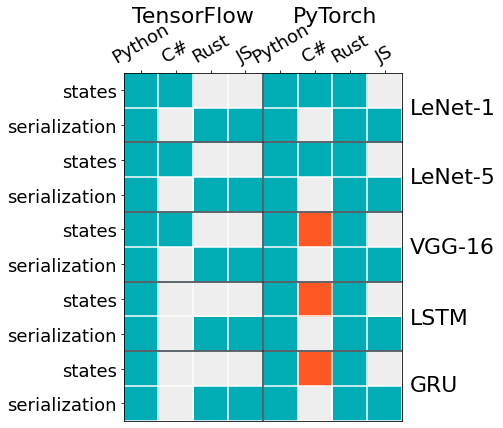

In [9]:
plot_data = np.zeros((10, 8)).tolist()
col_names = ["py", "dotnet", "rs", "ts"] * 2
row_names = ["states", "serialization"] * 5
models = ["lenet1", "lenet5", "vgg16", "lstm", "gru"]
for row in range(len(plot_data)):
    for col in range(len(plot_data[0])):
        fw = "tensorflow" if col < 4 else "pytorch"
        lang = col_names[col]
        mode = row_names[row]
        model = models[row // 2]
        if fw == "tensorflow" and model == "gru" and lang == "ts":
            model = "grurb"
        mask = \
            (inference_infos_df["framework"] == fw) \
            & (inference_infos_df["mode"] == mode) \
            & (inference_infos_df["model"] == model) \
            & (inference_infos_df["device"] == "gpu") \
            & (inference_infos_df["language"] == lang)
        value = inference_infos_df[mask]["reproduced"].values[0]
        if np.isnan(value):
            plot_data[row][col] = (238, 238, 238)
        elif value == False:
            plot_data[row][col] = (255, 87, 37)
        elif value == True:
            plot_data[row][col] = (0, 173, 181)
        else:
            raise ValueError()

fig, ax = plt.subplots()
fig.set_size_inches((14 * 0.8, 8 * 0.8))

im = ax.imshow(plot_data, cmap="Blues")

plt.hlines(y=np.arange(0, 10)+0.5, xmin=np.full(10, 0)-0.5, xmax=np.full(10, 8)-0.5, color="w")
plt.vlines(x=np.arange(0, 8)+0.5, ymin=np.full(8, 0)-0.5, ymax=np.full(8, 10)-0.5, color="w")
plt.vlines(x=3.5, ymin=-0.5, ymax=9.5, color="#303841")
plt.hlines(y=np.arange(1, 8, 2)+0.5, xmin=np.full(4, 0)-0.5, xmax=np.full(4, 8)-0.5, color="#303841")

ax.set_xticks(np.arange(len(col_names)))
ax.set_yticks(np.arange(len(row_names)))
ax.tick_params(top=True, bottom=False, labeltop=True, labelbottom=False)
ax.set_xticklabels(
    [LANG_SHOW_MAP[c] for c in col_names], size=18, rotation=30,
    ha='center'
)
ax.set_yticklabels([MODE_SHOW_MAP[r] for r in row_names], size=18)
LABELS_MODEL = ['  GRU  ' , ' LSTM ', 'VGG-16', 'LeNet-5', 'LeNet-1']

LARGER_FONT = 22
offset = 0.48
plt.figtext(0.215 + offset, 0.19, "GRU", fontsize=LARGER_FONT)
plt.figtext(0.215 + offset, 0.335, "LSTM", fontsize=LARGER_FONT)
plt.figtext(0.215 + offset, 0.49, "VGG-16", fontsize=LARGER_FONT)
plt.figtext(0.215 + offset, 0.64, "LeNet-5", fontsize=LARGER_FONT)
plt.figtext(0.215 + offset, 0.79, "LeNet-1", fontsize=LARGER_FONT)

plt.figtext(0.35, 0.99, "TensorFlow", fontsize=LARGER_FONT)
plt.figtext(0.55, 0.99, "PyTorch", fontsize=LARGER_FONT)

plt.show()
fig.savefig(OUT_FIGS_PATH / f"Fig5.eps", bbox_inches='tight')

## RQ3. How do the studied bindings impact the training time of the studied DL models?

### Collecting time cost of training experiments

In [10]:
def readTimeCostTxt(paths):
    time_costs = []
    for p in paths:
        data = np.loadtxt(p)[2]
        time_costs.append(data)
    return time_costs

def readTimeCostTxtTS(paths):
    time_costs = []
    for p in paths:
        with open(p, "r") as f:
            data = float(f.readlines()[1])
        time_costs.append(data)
    return time_costs

def readTimeCostJson(paths):
    time_costs = []
    for p in paths:
        data = loadJson(p)["training_time"]
        time_costs.append(data)
    return time_costs

def getTrainingTimeCostPath(framework, model, language):
    out_path = getPath(framework, model, language)
    if out_path is None:
        return []
    time_cost_path = out_path.glob("time_cost_*")
    return list(time_cost_path)

def getTrainingTimeCost(framework, model, language):
    paths = getTrainingTimeCostPath(framework, model, language)
    if paths is None:
        return []
    if language == "py":
        time_costs = readTimeCostJson(paths)
    elif language == "ts":
        time_costs = readTimeCostTxtTS(paths)
    else:
        time_costs = readTimeCostTxt(paths)
    return time_costs

time_costs_dic = {
    "framework": [],
    "model": [],
    "language": [],
    "time_cost": [],
}
time_costs_bar_plot = {}

def collectTimeCosts(FRAMEWORKS, models, languages):
    for fw in FRAMEWORKS:
        fw_name = fw[:-len("_lr_only")] if fw.endswith("_lr_only") else fw
        time_costs_bar_plot.setdefault(fw_name, {})
        for model in models:
            time_costs_bar_plot[fw_name].setdefault(model, {})
            for lang in languages:
                time_costs = getTrainingTimeCost(fw, model, lang)
                mid_time_cost = np.median(time_costs)
                time_costs_bar_plot[fw_name][model][lang] = time_costs
                time_costs_dic["framework"].append(fw_name)
                time_costs_dic["model"].append(model)
                time_costs_dic["language"].append(lang)
                time_costs_dic["time_cost"].append(mid_time_cost)

collectTimeCosts(
    ["tensorflow", "pytorch"],
    ["lenet1", "lenet5", "vgg16"],
    ["py", "dotnet", "rs", "ts"]
)
collectTimeCosts(
    ["tensorflow", "pytorch"],
    ["lstm", "gru", "grurb"],
    ["py", "dotnet", "rs", "ts"]
)

time_costs_df = pd.DataFrame(data=time_costs_dic)
# time_costs_df.groupby(["framework", "model"]).apply(display)

/home/leo/anaconda3/envs/pytorch_gpu/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/leo/anaconda3/envs/pytorch_gpu/lib/python3.9/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


### Plotting the results

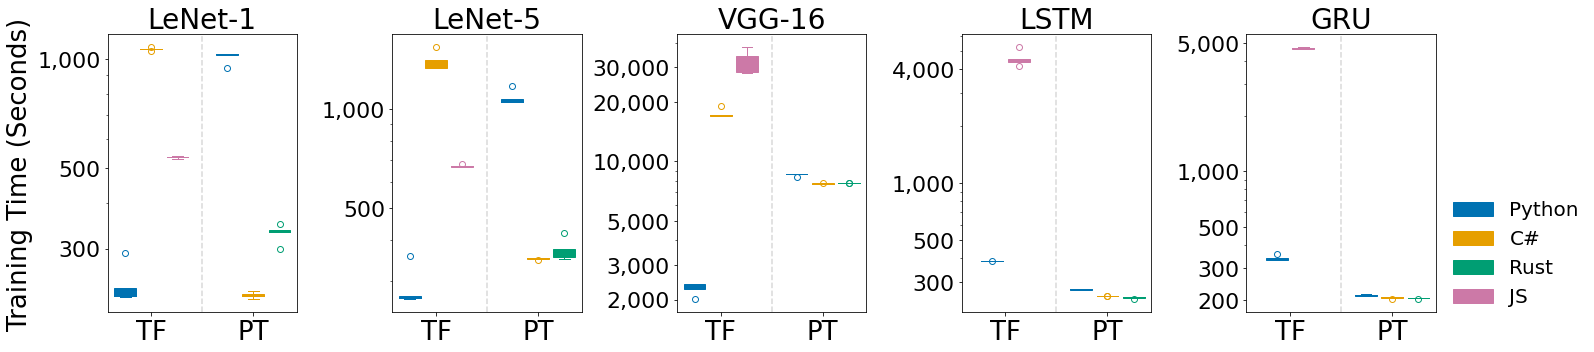

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


In [11]:
TITLE_SIZE = 28
XLABEL_SIZE = 26
STICK_SIZE = 22
LEGEND_SIZE = 20
labels = ['TF', 'PT']

x = np.array([1.1, 1.8])
width = 0.18  # the width of the bars

rects = []

def axConfig(ax):
    ax.tick_params(axis='y', labelsize=STICK_SIZE)
    ax.set_xticks(x)
    ax.set_xticklabels(labels, fontsize=XLABEL_SIZE)
    ax.set_xlim([0.8, 2.1])

def box_plot(ax, positions, data, edge_color, fill_color):
    bp = ax.boxplot(
        data, patch_artist=True, positions=positions,
        flierprops={"markeredgecolor": edge_color},
    )
    for element in ['boxes', 'whiskers', 'fliers', 'means', 'medians', 'caps']:
        plt.setp(bp[element], color=edge_color)

    for patch in bp['boxes']:
        patch.set(facecolor=fill_color)
    return bp


fig, axs = plt.subplots(1, 5)
fig.set_size_inches((23, 5))

yticks = [
    [300, 500, 1000],
    [500, 1000],
    [2000, 3000, 5000, 10000, 20000, 30000],
]
ytick_labels = [
    ["300", "500", "1,000"],
    ["500", "1,000"],
    ["2,000", "3,000", "5,000", "10,000", "20,000", "30,000"],
]
for model, ax, ticks, ticklabels in zip(["lenet1", "lenet5", "vgg16"], axs[:3], yticks, ytick_labels):
    bp1 = box_plot(
        ax, x - width,
        [time_costs_bar_plot["tensorflow"][model]["py"], time_costs_bar_plot["pytorch"][model]["py"]],
        COLOR_MAP["py"], COLOR_MAP["py"]
    )
    bp2 = box_plot(
        ax, x,
        [time_costs_bar_plot["tensorflow"][model]["dotnet"], time_costs_bar_plot["pytorch"][model]["dotnet"]],
        COLOR_MAP["dotnet"], COLOR_MAP["dotnet"]
    )
    bp3 = box_plot(
        ax, [x[0] + width],
        [time_costs_bar_plot["tensorflow"][model]["ts"]],
        COLOR_MAP["ts"], COLOR_MAP["ts"]
    )
    bp4 = box_plot(
        ax, [x[1] + width],
        [time_costs_bar_plot["pytorch"][model]["rs"]],
        COLOR_MAP["rs"], COLOR_MAP["rs"]
    )
    ax.axvline(np.median(x), ls="--", color="gray", alpha=0.3)
    ax.set_title(MODELS_SHOW_MAP[model], fontsize=TITLE_SIZE)
    axConfig(ax)

    ax.set_yscale("log")
    ax.set_yticks(ticks)
    ax.set_yticklabels(ticklabels, fontsize=STICK_SIZE)
    ax.set_yticklabels([], minor=True)

ax = axs[3]
bp1 = box_plot(
    ax, x - np.array([width / 2, width]),
    [time_costs_bar_plot["tensorflow"]["lstm"]["py"], time_costs_bar_plot["pytorch"]["lstm"]["py"]],
    COLOR_MAP["py"], COLOR_MAP["py"]
)
bp2 = box_plot(
    ax, [x[1]],
    [time_costs_bar_plot["pytorch"]["lstm"]["dotnet"]],
    COLOR_MAP["dotnet"], COLOR_MAP["dotnet"]
)
bp3 = box_plot(
    ax, [x[0] + width / 2],
    [time_costs_bar_plot["tensorflow"]["lstm"]["ts"],],
    COLOR_MAP["ts"], COLOR_MAP["ts"]
)
bp4 = box_plot(
    ax, [x[1] + width],
    [time_costs_bar_plot["pytorch"]["lstm"]["rs"]],
    COLOR_MAP["rs"], COLOR_MAP["rs"]
)
axConfig(ax)
ax.set_yscale("log")
ax.set_yticks([300, 500, 1000, 4000])
ax.set_yticklabels(["300", "500", "1,000", "4,000"], fontsize=STICK_SIZE)
ax.axvline(np.median(x), ls="--", color="gray", alpha=0.3)
ax.set_title(MODELS_SHOW_MAP["lstm"], fontsize=TITLE_SIZE)

ax = axs[4]
bp1 = box_plot(
    ax, x - np.array([width / 2, width]),
    [time_costs_bar_plot["tensorflow"]["gru"]["py"], time_costs_bar_plot["pytorch"]["gru"]["py"]],
    COLOR_MAP["py"], COLOR_MAP["py"]
)
bp2 = box_plot(
    ax, [x[1]],
    [time_costs_bar_plot["pytorch"]["gru"]["dotnet"]],
    COLOR_MAP["dotnet"], COLOR_MAP["dotnet"]
)
bp3 = box_plot(
    ax, [x[0] + width / 2],
    [time_costs_bar_plot["tensorflow"]["grurb"]["ts"],],
    COLOR_MAP["ts"], COLOR_MAP["ts"]
)
bp4 = box_plot(
    ax, [x[1] + width],
    [time_costs_bar_plot["pytorch"]["gru"]["rs"]],
    COLOR_MAP["rs"], COLOR_MAP["rs"]
)

axConfig(ax)
ax.set_yscale("log")
ax.set_yticks([200, 300, 500, 1000, 5000])
ax.set_yticklabels(["200", "300", "500", "1,000", "5,000"], fontsize=STICK_SIZE)
ax.axvline(np.median(x), ls="--", color="gray", alpha=0.3)
ax.set_title(MODELS_SHOW_MAP["gru"], fontsize=TITLE_SIZE)
plt.legend(
    [bp1["boxes"][0], bp2["boxes"][0], bp4["boxes"][0], bp3["boxes"][0]],
    ['Python', 'C#', "Rust", "JS"],
    bbox_to_anchor=(1.05, 0.43), borderaxespad=0, fontsize=LEGEND_SIZE,
    frameon=False
)
axs[0].set_ylabel("Training Time (Seconds)", fontsize=XLABEL_SIZE)
plt.subplots_adjust(wspace=-1)
fig.tight_layout()
plt.show()
fig.savefig(OUT_FIGS_PATH / f"Fig6.eps", bbox_inches='tight')

### Mann-Whitney U test and Cliff's delta d

In [12]:
def printScale(value, lang1, total, lang2):
    if value > total:
        print(f"{value} ({lang1}) / {total} ({lang2}) = {value / total} times faster")
    else:
        print(f"{total} ({lang2}) / {value} ({lang1}) = {total / value} tims slower")

def mannUandCliffdelta(dist1, dist2, printRes=True):
    d, size = cliffdelta.cliffsDelta(dist1, dist2)
    u, p = mannwhitneyu(dist1, dist2, alternative="two-sided")
    if printRes:
        print(f"{np.median(dist1)} vs. {np.median(dist2)}")
        print(f"Cliff's delta: {size}, d={d}")
        print(f"Mann-Whitney-U-test: u={u} p={p}")
    return u, p, d, size

p_values_info = {
    "framework": [],
    "model": [],
    "lang": [],
    "mann_u": [],
    "eff_size": [],
    "p_value": [],
    "cliff_d": [],
}
p_values = {}
for fw in ["tensorflow", "pytorch"]:
    p_values.setdefault(fw, {})
    for model in ["lenet1", "lenet5", "vgg16", "lstm", "gru", "grurb"]:
        p_values[fw].setdefault(model, [])
        print(f"============= {fw} x {model} ===============")
        languages = ["py", "dotnet", "rs", "ts"]
        i = 0
        ref_lang = languages[i]
        for j in range(i + 1, len(languages)):
            lang = languages[j]
            if lang not in time_costs_bar_plot[fw][model]:
                continue
            if len(time_costs_bar_plot[fw][model][lang]) == 0:
                continue
            printScale(
                np.median(time_costs_bar_plot[fw][model][ref_lang]), ref_lang,
                np.median(time_costs_bar_plot[fw][model][lang]), lang
            )
            u, p, d, size = mannUandCliffdelta(
                time_costs_bar_plot[fw][model][ref_lang],
                time_costs_bar_plot[fw][model][lang], printRes=False
            )
            p_values[fw][model].append(p)
            p_values_info["framework"].append(fw)
            p_values_info["model"].append(model)
            p_values_info["lang"].append(f"{ref_lang} - {lang}")
            p_values_info["mann_u"].append(u)
            p_values_info["eff_size"].append(size)
            p_values_info["p_value"].append(p)
            p_values_info["cliff_d"].append(d)
p_values_info = pd.DataFrame.from_dict(p_values_info)
p_values_info.groupby(["framework", "model"]).apply(display)

============= tensorflow x lenet1 ===============
1065.114140700005 (dotnet) / 222.09142881911248 (py) = 4.795836320038771 tims slower
537.631 (ts) / 222.09142881911248 (py) = 2.420764289998269 tims slower
============= tensorflow x lenet5 ===============
1334.8858165000001 (dotnet) / 267.81001583486795 (py) = 4.98445068358867 tims slower
670.9459999999999 (ts) / 267.81001583486795 (py) = 2.505305852390921 tims slower
============= tensorflow x vgg16 ===============
17236.038959599995 (dotnet) / 2356.849294008687 (py) = 7.313169748874263 tims slower
29488.418 (ts) / 2356.849294008687 (py) = 12.511796182709725 tims slower
============= tensorflow x lstm ===============
4421.887000000002 (ts) / 385.47948511876166 (py) = 11.471134446072199 tims slower
============= tensorflow x gru ===============
============= tensorflow x grurb ===============
4655.218000000004 (ts) / 1354.2509506968781 (py) = 3.437485495287632 tims slower
============= pytorch x lenet1 ===============
1030.727756082080

,framework,model,lang,mann_u,eff_size,p_value,cliff_d
16,pytorch,gru,py - dotnet,25.0,large,0.007937,1.0
17,pytorch,gru,py - rs,25.0,large,0.007937,1.0


,framework,model,lang,mann_u,eff_size,p_value,cliff_d
8,pytorch,lenet1,py - dotnet,25.0,large,0.007937,1.0
9,pytorch,lenet1,py - rs,25.0,large,0.007937,1.0


,framework,model,lang,mann_u,eff_size,p_value,cliff_d
10,pytorch,lenet5,py - dotnet,25.0,large,0.007937,1.0
11,pytorch,lenet5,py - rs,25.0,large,0.007937,1.0


,framework,model,lang,mann_u,eff_size,p_value,cliff_d
14,pytorch,lstm,py - dotnet,25.0,large,0.007937,1.0
15,pytorch,lstm,py - rs,25.0,large,0.007937,1.0


,framework,model,lang,mann_u,eff_size,p_value,cliff_d
12,pytorch,vgg16,py - dotnet,25.0,large,0.007937,1.0
13,pytorch,vgg16,py - rs,25.0,large,0.007937,1.0


,framework,model,lang,mann_u,eff_size,p_value,cliff_d
7,tensorflow,grurb,py - ts,0.0,large,0.007937,-1.0


,framework,model,lang,mann_u,eff_size,p_value,cliff_d
0,tensorflow,lenet1,py - dotnet,0.0,large,0.007937,-1.0
1,tensorflow,lenet1,py - ts,0.0,large,0.007937,-1.0


,framework,model,lang,mann_u,eff_size,p_value,cliff_d
2,tensorflow,lenet5,py - dotnet,0.0,large,0.007937,-1.0
3,tensorflow,lenet5,py - ts,0.0,large,0.007937,-1.0


,framework,model,lang,mann_u,eff_size,p_value,cliff_d
6,tensorflow,lstm,py - ts,0.0,large,0.007937,-1.0


,framework,model,lang,mann_u,eff_size,p_value,cliff_d
4,tensorflow,vgg16,py - dotnet,0.0,large,0.007937,-1.0
5,tensorflow,vgg16,py - ts,0.0,large,0.007937,-1.0


""


### Bonferroni correction

In [13]:
p_values_info.groupby(["framework", "model"]).apply(
    lambda df: statsmodels.stats.multitest.multipletests(df["p_value"], method="bonferroni")[0]
)

framework   model 
pytorch     gru       [True, True]
            lenet1    [True, True]
            lenet5    [True, True]
            lstm      [True, True]
            vgg16     [True, True]
tensorflow  grurb           [True]
            lenet1    [True, True]
            lenet5    [True, True]
            lstm            [True]
            vgg16     [True, True]
dtype: object

## RQ4. How do the studied bindings impact the inference time of pre-trained models?

### Collecting inference time cost

In [14]:
deploy_times = {}
testset_durations = {}
for fw in ["tensorflow", "pytorch"]:
    for model in MODELS:
        for lang in LANGUAGES:
            for device in ["cpu", "gpu"]:
                mask = \
                    (inference_infos_df["framework"] == fw) \
                    & (inference_infos_df["model"] == model) \
                    & (inference_infos_df["language"] == lang) \
                    & (inference_infos_df["device"] == device)
                time_cost_vals = inference_infos_df[mask].dropna()["time_cost"].values
                testset_duration = inference_infos_df[mask].dropna()["testset_duration"].values
                if len(time_cost_vals):
                    deploy_times.setdefault(f"{fw}_{model}_{lang}", {})
                    testset_durations.setdefault(f"{fw}_{model}_{lang}", {})
                    # deploy_times[f"{fw}_{model}_{lang}"][device] = time_cost_vals
                    testset_durations[f"{fw}_{model}_{lang}"][device] = reduce(lambda x, y: x + y, testset_duration)
                    deploy_times[f"{fw}_{model}_{lang}"][device] = np.mean(time_cost_vals)

### Plotting inference time cost

[[0.8578321849927306, 0.8349432363174856, 0.8484589750878513, 0.8329676520079374, 0.8563888354692608, 0.8456464579794556, 0.84889355301857, 0.8815059142652899, 0.8691329618450254, 0.8620407367125154], [2.8518869799999997, 2.9421466, 2.84642026, 2.82668006, 2.8595876999999996], [0.5944625589999999, 0.5934407986, 0.6200759828, 0.5632670456, 0.5986516712000001], [1.6542000000000001, 1.6852, 1.6426000000000003, 1.6538, 1.6794], [0.9866661573760211, 1.1768949599936604, 0.9048424244392663, 0.8536215387284756, 0.9660377709660679, 0.8878365762066096, 0.8882840049918741, 0.872311650775373, 0.963793964125216, 0.936618132982403], [0.11734444000000002, 0.10852096, 0.11780786000000001, 0.12426725999999999, 0.1121022], [0.1050741754, 0.1037912354, 0.1047940668, 0.1099009324, 0.1040809734, 0.0998907292, 0.1136599056, 0.0967957282, 0.0981845106, 0.0993295654], [3.3728000000000002, 3.1567999999999996, 3.2252, 4.138199999999999, 3.9878]]
[[0.6820610975846648, 0.6803916618227959, 0.69250662997365, 0.6791

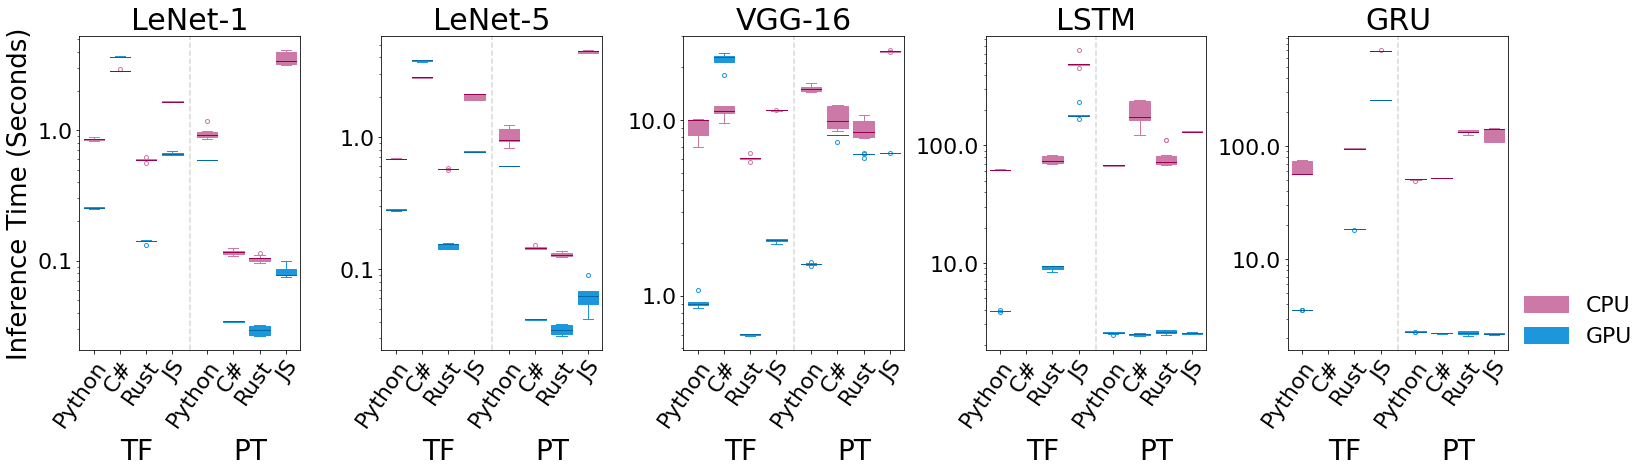

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


In [15]:
YTICKS_SIZE = 22
XTICKS_SIZE = 22
YLABEL_SIZE = 26
LEGEND_SIZE = 22
XLABEL_SIZE = 28
TITLE_SIZE = 30

cpu_color = "#CC79A7"
cpu_color_darker = "#990054"
gpu_color = "#1e96dc"
gpu_color_darker = "#006ba8"
fig, axs = plt.subplots(1, 5)
fig.set_size_inches((23, 7))
x_ticks = [1.1, 2, 2.9, 3.8, 5.0, 5.9, 6.8, 7.7]

data_cpus = {}
data_gpus = {}
for model, ax in zip(MODELS[:-1], axs):
    data_cpu = []
    data_gpu = []
    for fw in ["tensorflow", "pytorch"]:
        for lang in LANGUAGES:
            if lang == "ts" and model == "gru" and fw == "tensorflow":
                key_name = f"{fw}_grurb_{lang}"
            else:
                key_name = f"{fw}_{model}_{lang}"
            if key_name not in testset_durations:
                data_cpu.append(np.nan)
                data_gpu.append(np.nan)
            else:
                data_cpu.append(testset_durations[key_name]["cpu"])
                data_gpu.append(testset_durations[key_name]["gpu"])
    print(data_cpu)
    box_cpu = ax.boxplot(
        data_cpu,
        positions=x_ticks,
        patch_artist=True, widths=0.7,
        flierprops={"markeredgecolor": cpu_color, "markersize": 4},
    )
    box_gpu = ax.boxplot(
        data_gpu,
        positions=x_ticks,
        patch_artist=True, widths=0.7,
        flierprops={"markeredgecolor": gpu_color, "markersize": 4}
    )

    for element in ['boxes', 'whiskers', 'fliers', 'caps']:
        plt.setp(box_cpu[element], color=cpu_color)
    plt.setp(box_cpu['medians'], color=cpu_color_darker)
    for patch in box_cpu['boxes']:
        patch.set(facecolor=cpu_color)

    for element in ['boxes', 'whiskers', 'fliers', 'caps']:
        plt.setp(box_gpu[element], color=gpu_color)
    plt.setp(box_gpu['medians'], color=gpu_color_darker)
    for patch in box_gpu['boxes']:
        patch.set(facecolor=gpu_color)

    ax.axvline(np.median(x_ticks), ls="--", color="gray", alpha=0.3)
    ax.set_xticks(x_ticks)
    ax.set_xticklabels(
        [LANG_SHOW_MAP[c] for c in col_names], size=XTICKS_SIZE, rotation=55,
        ha='right', rotation_mode='anchor'
    )
    ax.set_title(MODELS_SHOW_MAP[model], fontsize=TITLE_SIZE)

    ax.set_yscale("log")
    ax.yaxis.set_major_formatter(FormatStrFormatter('%.1f'))
    trans = transforms.blended_transform_factory(
        ax.transData, ax.transAxes)

    ax.text(2, -0.35, "TF", transform=trans, fontsize=XLABEL_SIZE)
    ax.text(5.9, -0.35, "PT", transform=trans, fontsize=XLABEL_SIZE)
    ax.tick_params(axis='y', labelsize=YTICKS_SIZE)
    data_cpus[model] = data_cpu
    data_gpus[model] = data_gpu


plt.legend(
    [box_cpu["boxes"][0], box_gpu["boxes"][0]],
    ['CPU', 'GPU'], bbox_to_anchor=(1.03, 0.2), borderaxespad=0, fontsize=LEGEND_SIZE,
    frameon=False
)
axs[0].set_ylabel("Inference Time (Seconds)", fontsize=YLABEL_SIZE)
plt.subplots_adjust(wspace=0)
fig.tight_layout()
plt.show()
fig.savefig(OUT_FIGS_PATH / f"Fig7.eps", bbox_inches='tight')

### Mann-Whitney U test and Cliff's delta d for Python vs. Non-Python bindings


In [16]:
infer_cmp = {
    "framework": [],
    "model": [],
    "lang": [],
    "mann_u": [],
    "eff_size": [],
    "p_value": [],
    "cliff_d": [],
    "device": [],
}
def calData(fw, model, device, data):
    ps = []
    i = 0
    ref = data[0]
    for j in range(i + 1, len(data)):
        d = data[j]
        if isinstance(d, float):
            continue
        # print(f"=========== {LANGUAGES[i]} vs {LANGUAGES[j]} ============")
        printScale(np.median(ref), LANGUAGES[i], np.median(d), LANGUAGES[j])
        u, p, cliff_d, size = mannUandCliffdelta(ref, d, printRes=False)
        infer_cmp["framework"].append(fw)
        infer_cmp["model"].append(model)
        infer_cmp["lang"].append(f"{LANGUAGES[i]}-{LANGUAGES[j]}")
        infer_cmp["mann_u"].append(u)
        infer_cmp["eff_size"].append(size)
        infer_cmp["p_value"].append(p)
        infer_cmp["cliff_d"].append(cliff_d)
        infer_cmp["device"].append(device)

for model in MODELS[:-1]:
    data_tf_cpu = data_cpus[model][:4]
    data_tf_gpu = data_gpus[model][:4]
    data_tch_cpu = data_cpus[model][-4:]
    data_tch_gpu = data_gpus[model][-4:]
    print(f"*************** TensorFlow x {model} cpu ***************")
    calData("tensorflow", model, "cpu", data_tf_cpu)
    print(f"*************** TensorFlow x {model} gpu ***************")
    calData("tensorflow", model, "gpu", data_tf_gpu)
    print(f"*************** PyTorch x {model} cpu ***************")
    calData("pytorch", model, "cpu", data_tch_cpu)
    print(f"*************** PyTorch x {model} gpu ***************")
    calData("pytorch", model, "gpu", data_tch_gpu)
infer_cmp = pd.DataFrame.from_dict(infer_cmp)
infer_cmp.groupby(["framework", "model", "device"]).apply(display)

*************** TensorFlow x lenet1 cpu ***************
2.8518869799999997 (dotnet) / 0.8526411942439154 (py) = 3.3447679976674447 tims slower
0.8526411942439154 (py) / 0.5944625589999999 (rs) = 1.434305964833549 times faster
1.6542000000000001 (ts) / 0.8526411942439154 (py) = 1.9400892323374919 tims slower
*************** TensorFlow x lenet1 gpu ***************
3.64313712 (dotnet) / 0.25389744411222637 (py) = 14.348853068365983 tims slower
0.25389744411222637 (py) / 0.1417206336 (rs) = 1.7915347798178793 times faster
0.6616000000000001 (ts) / 0.25389744411222637 (py) = 2.6057765264764274 tims slower
*************** PyTorch x lenet1 cpu ***************
0.9207302787108347 (py) / 0.11734444000000002 (dotnet) = 7.846390325019528 times faster
0.9207302787108347 (py) / 0.1039361044 (rs) = 8.858618321573678 times faster
3.3728000000000002 (ts) / 0.9207302787108347 (py) = 3.663179193718321 tims slower
*************** PyTorch x lenet1 gpu ***************
0.5929149857256562 (py) / 0.03416326 (d

,framework,model,lang,mann_u,eff_size,p_value,cliff_d,device
50,pytorch,gru,py-dotnet,0.0,large,0.000666,-1.0,cpu
51,pytorch,gru,py-rs,0.0,large,0.000183,-1.0,cpu
52,pytorch,gru,py-ts,0.0,large,0.000666,-1.0,cpu


,framework,model,lang,mann_u,eff_size,p_value,cliff_d,device
53,pytorch,gru,py-dotnet,50.0,large,0.000666,1.00,gpu
54,pytorch,gru,py-rs,54.0,negligible,0.791337,0.08,gpu
55,pytorch,gru,py-ts,50.0,large,0.000666,1.00,gpu


,framework,model,lang,mann_u,eff_size,p_value,cliff_d,device
6,pytorch,lenet1,py-dotnet,50.0,large,0.000666,1.0,cpu
7,pytorch,lenet1,py-rs,100.0,large,0.000183,1.0,cpu
8,pytorch,lenet1,py-ts,0.0,large,0.000666,-1.0,cpu


,framework,model,lang,mann_u,eff_size,p_value,cliff_d,device
9,pytorch,lenet1,py-dotnet,50.0,large,0.000666,1.0,gpu
10,pytorch,lenet1,py-rs,100.0,large,0.000183,1.0,gpu
11,pytorch,lenet1,py-ts,50.0,large,0.000666,1.0,gpu


,framework,model,lang,mann_u,eff_size,p_value,cliff_d,device
18,pytorch,lenet5,py-dotnet,50.0,large,0.000666,1.0,cpu
19,pytorch,lenet5,py-rs,100.0,large,0.000183,1.0,cpu
20,pytorch,lenet5,py-ts,0.0,large,0.000666,-1.0,cpu


,framework,model,lang,mann_u,eff_size,p_value,cliff_d,device
21,pytorch,lenet5,py-dotnet,50.0,large,0.000666,1.0,gpu
22,pytorch,lenet5,py-rs,100.0,large,0.000183,1.0,gpu
23,pytorch,lenet5,py-ts,50.0,large,0.000666,1.0,gpu


,framework,model,lang,mann_u,eff_size,p_value,cliff_d,device
40,pytorch,lstm,py-dotnet,0.0,large,0.000666,-1.00,cpu
41,pytorch,lstm,py-rs,3.0,large,0.000440,-0.94,cpu
42,pytorch,lstm,py-ts,0.0,large,0.000666,-1.00,cpu


,framework,model,lang,mann_u,eff_size,p_value,cliff_d,device
43,pytorch,lstm,py-dotnet,43.0,large,0.027972,0.72,gpu
44,pytorch,lstm,py-rs,34.0,small,0.241322,-0.32,gpu
45,pytorch,lstm,py-ts,33.0,small,0.370962,0.32,gpu


,framework,model,lang,mann_u,eff_size,p_value,cliff_d,device
30,pytorch,vgg16,py-dotnet,50.0,large,0.000666,1.0,cpu
31,pytorch,vgg16,py-rs,100.0,large,0.000183,1.0,cpu
32,pytorch,vgg16,py-ts,0.0,large,0.000666,-1.0,cpu


,framework,model,lang,mann_u,eff_size,p_value,cliff_d,device
33,pytorch,vgg16,py-dotnet,0.0,large,0.000666,-1.0,gpu
34,pytorch,vgg16,py-rs,0.0,large,0.000183,-1.0,gpu
35,pytorch,vgg16,py-ts,0.0,large,0.000666,-1.0,gpu


,framework,model,lang,mann_u,eff_size,p_value,cliff_d,device
46,tensorflow,gru,py-rs,0.0,large,0.000666,-1.0,cpu
47,tensorflow,gru,py-ts,0.0,large,0.000666,-1.0,cpu


,framework,model,lang,mann_u,eff_size,p_value,cliff_d,device
48,tensorflow,gru,py-rs,0.0,large,0.000666,-1.0,gpu
49,tensorflow,gru,py-ts,0.0,large,0.000666,-1.0,gpu


,framework,model,lang,mann_u,eff_size,p_value,cliff_d,device
0,tensorflow,lenet1,py-dotnet,0.0,large,0.000666,-1.0,cpu
1,tensorflow,lenet1,py-rs,50.0,large,0.000666,1.0,cpu
2,tensorflow,lenet1,py-ts,0.0,large,0.000666,-1.0,cpu


,framework,model,lang,mann_u,eff_size,p_value,cliff_d,device
3,tensorflow,lenet1,py-dotnet,0.0,large,0.000666,-1.0,gpu
4,tensorflow,lenet1,py-rs,50.0,large,0.000666,1.0,gpu
5,tensorflow,lenet1,py-ts,0.0,large,0.000666,-1.0,gpu


,framework,model,lang,mann_u,eff_size,p_value,cliff_d,device
12,tensorflow,lenet5,py-dotnet,0.0,large,0.000666,-1.0,cpu
13,tensorflow,lenet5,py-rs,50.0,large,0.000666,1.0,cpu
14,tensorflow,lenet5,py-ts,0.0,large,0.000666,-1.0,cpu


,framework,model,lang,mann_u,eff_size,p_value,cliff_d,device
15,tensorflow,lenet5,py-dotnet,0.0,large,0.000666,-1.0,gpu
16,tensorflow,lenet5,py-rs,50.0,large,0.000666,1.0,gpu
17,tensorflow,lenet5,py-ts,0.0,large,0.000666,-1.0,gpu


,framework,model,lang,mann_u,eff_size,p_value,cliff_d,device
36,tensorflow,lstm,py-rs,0.0,large,0.000666,-1.0,cpu
37,tensorflow,lstm,py-ts,0.0,large,0.000666,-1.0,cpu


,framework,model,lang,mann_u,eff_size,p_value,cliff_d,device
38,tensorflow,lstm,py-rs,0.0,large,0.000666,-1.0,gpu
39,tensorflow,lstm,py-ts,0.0,large,0.000666,-1.0,gpu


,framework,model,lang,mann_u,eff_size,p_value,cliff_d,device
24,tensorflow,vgg16,py-dotnet,7.0,large,0.027972,-0.72,cpu
25,tensorflow,vgg16,py-rs,50.0,large,0.000666,1.00,cpu
26,tensorflow,vgg16,py-ts,0.0,large,0.000666,-1.00,cpu


,framework,model,lang,mann_u,eff_size,p_value,cliff_d,device
27,tensorflow,vgg16,py-dotnet,0.0,large,0.000666,-1.0,gpu
28,tensorflow,vgg16,py-rs,50.0,large,0.000666,1.0,gpu
29,tensorflow,vgg16,py-ts,0.0,large,0.000666,-1.0,gpu


""


### Bonferroni correction

In [17]:
infer_cmp.groupby(["framework", "model", "device"]).apply(
    lambda df: statsmodels.stats.multitest.multipletests(df["p_value"], method="bonferroni")[0]
)

framework   model   device
pytorch     gru     cpu          [True, True, True]
                    gpu         [True, False, True]
            lenet1  cpu          [True, True, True]
                    gpu          [True, True, True]
            lenet5  cpu          [True, True, True]
                    gpu          [True, True, True]
            lstm    cpu          [True, True, True]
                    gpu       [False, False, False]
            vgg16   cpu          [True, True, True]
                    gpu          [True, True, True]
tensorflow  gru     cpu                [True, True]
                    gpu                [True, True]
            lenet1  cpu          [True, True, True]
                    gpu          [True, True, True]
            lenet5  cpu          [True, True, True]
                    gpu          [True, True, True]
            lstm    cpu                [True, True]
                    gpu                [True, True]
            vgg16   cpu         [Fals

### CPU vs. GPU

In [18]:
device_cmp = {
    "framework": [],
    "model": [],
    "lang": [],
    "mann_u": [],
    "eff_size": [],
    "p_value": [],
    "cliff_d": [],
}

for model in MODELS[:-1]:
    data_tf_cpu = data_cpus[model][:4]
    data_tf_gpu = data_gpus[model][:4]
    for i, lang in enumerate(LANGUAGES):
        if isinstance(data_tf_cpu[i], float) or isinstance(data_tf_gpu[i], float):
            continue
        u, p, cliff_d, size = mannUandCliffdelta(data_tf_cpu[i], data_tf_gpu[i], printRes=False)
        device_cmp["framework"].append("tensorflow")
        device_cmp["model"].append(model)
        device_cmp["lang"].append(lang)
        device_cmp["mann_u"].append(u)
        device_cmp["eff_size"].append(size)
        device_cmp["p_value"].append(p)
        device_cmp["cliff_d"].append(cliff_d)

for model in MODELS[:-1]:
    data_tch_cpu = data_cpus[model][-4:]
    data_tch_gpu = data_gpus[model][-4:]
    for i, lang in enumerate(LANGUAGES):
        if isinstance(data_tch_cpu[i], float) or isinstance(data_tch_gpu[i], float):
            continue
        u, p, cliff_d, size = mannUandCliffdelta(data_tch_cpu[i], data_tch_gpu[i], printRes=False)
        device_cmp["framework"].append("pytorch")
        device_cmp["model"].append(model)
        device_cmp["lang"].append(lang)
        device_cmp["mann_u"].append(u)
        device_cmp["eff_size"].append(size)
        device_cmp["p_value"].append(p)
        device_cmp["cliff_d"].append(cliff_d)

device_cmp = pd.DataFrame.from_dict(device_cmp)
print("how many p > 0.05?", sum(device_cmp["p_value"] > 0.05))
print("how many effect size not 'large'?", sum(device_cmp["eff_size"] != "large"))

how many p > 0.05? 0
how many effect size not 'large'? 0
